In [1]:
#--------------------------------------------------------------------------------------------------------------------
# By Alexandra Lee (July 2018) 
#
# Encode Pseudomonas gene expression data into low dimensional latent space using 
# Tybalt with 1-hidden layer
# -------------------------------------------------------------------------------------------------------------------
import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# To ensure reproducibility using Keras during development
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
randomState = 123
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import metrics, optimizers
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Files
# --------------------------------------------------------------------------------------------------------------------
data_file =  os.path.join(os.path.dirname(os.getcwd()), "data", "train_model_input.txt.xz")
rnaseq = pd.read_table(data_file,sep='\t',index_col=0, header=0, compression='xz')

In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Initialize hyper parameters
#
# learning rate: 
# batch size: Total number of training examples present in a single batch
#             Iterations is the number of batches needed to complete one epoch
# epochs: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
# kappa: warmup
# original dim: dimensions of the raw data
# latent dim: dimensiosn of the latent space (fixed by the user)
#   Note: intrinsic latent space dimension unknown
# epsilon std: 
# beta: Threshold value for ReLU?
# --------------------------------------------------------------------------------------------------------------------

learning_rate = 0.001
batch_size = 100
epochs = 500
kappa = 0.01

original_dim = rnaseq.shape[1]
latent_dim = 10
epsilon_std = 1.0
beta = K.variable(0)

stat_file =  os.path.join(os.path.dirname(os.getcwd()), "stats", "tybalt_1layer_{}latent_stats1.csv".format(latent_dim))
hist_plot_file =os.path.join(os.path.dirname(os.getcwd()), "stats", "tybalt_1layer_{}latent_hist1.png".format(latent_dim))

encoded_file =os.path.join(os.path.dirname(os.getcwd()), "encoded", "train_input_1layer_{}latent_encoded1.txt".format(latent_dim))

model_encoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_1layer_{}latent_encoder_model1.h5".format(latent_dim))
weights_encoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_1layer_{}latent_encoder_weights1.h5".format(latent_dim))
model_decoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_1layer_{}latent_decoder_model1.h5".format(latent_dim))
weights_decoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_1layer_{}latent_decoder_weights1.h5".format(latent_dim))

In [4]:
# --------------------------------------------------------------------------------------------------------------------
# Functions
#
# Based on publication by Greg et. al. 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5728678/
# https://github.com/greenelab/tybalt/blob/master/scripts/vae_pancancer.py
# --------------------------------------------------------------------------------------------------------------------

# Function for reparameterization trick to make model differentiable
def sampling(args):

    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)

    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * \
                              metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded -
                                K.square(z_mean_encoded) -
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x


class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [5]:
# --------------------------------------------------------------------------------------------------------------------
# Data initalizations
# --------------------------------------------------------------------------------------------------------------------

# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq.sample(frac=test_set_percent, random_state = randomState)
rnaseq_train_df = rnaseq.drop(rnaseq_test_df.index)

# Create a placeholder for an encoded (original-dimensional)
rnaseq_input = Input(shape=(original_dim, ))

In [6]:
# --------------------------------------------------------------------------------------------------------------------
# Architecture of VAE
# --------------------------------------------------------------------------------------------------------------------

# ENCODER

# Input layer is compressed into a mean and log variance vector of size
# `latent_dim`. Each layer is initialized with glorot uniform weights and each
# step (dense connections, batch norm,and relu activation) are funneled
# separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

# "z_mean_dense_linear" is the encoded representation of the input
#    Take as input arrays of shape (*, original dim) and output arrays of shape (*, latent dim)
#    Combine input from previous layer using linear summ
# Normalize the activations (combined weighted nodes of the previous layer)
#   Transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
# Apply ReLU activation function to combine weighted nodes from previous layer
#   relu = threshold cutoff (cutoff value will be learned)
#   ReLU function filters noise

# X is encoded using Q(z|X) to yield mu(X), sigma(X) that describes latent space distribution
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# Customized layer
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
#
# sampling():
# randomly sample similar points z from the latent normal distribution that is assumed to generate the data,
# via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor
# z ~ Q(z|X)
# Note: there is a trick to reparameterize to standard normal distribution so that the space is differentiable and 
# therefore gradient descent can be used
#
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
z = Lambda(sampling,
           output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])


# DECODER

# The decoding layer is much simpler with a single layer glorot uniform
# initialized and sigmoid activation
# Reconstruct P(X|z)
decoder_to_reconstruct = Dense(original_dim,
                               kernel_initializer='glorot_uniform',
                               activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)


# CONNECTIONS
# fully-connected network
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/ipykernel/__main__.py:66: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [7]:
# --------------------------------------------------------------------------------------------------------------------
# Training
# --------------------------------------------------------------------------------------------------------------------

# fit Model
# hist: record of the training loss at each epoch
hist = vae.fit(np.array(rnaseq_train_df), shuffle=True, epochs=epochs, batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa)])

Train on 1065 samples, validate on 118 samples
Epoch 1/500
1065/1065 [==============================] - 1s 762us/step - loss: 3830.9592 - val_loss: 3777.0667
Epoch 2/500
1065/1065 [==============================] - 1s 690us/step - loss: 3785.0205 - val_loss: 3751.1258
Epoch 3/500
1065/1065 [==============================] - 1s 673us/step - loss: 3740.3942 - val_loss: 3725.9802
Epoch 4/500
1065/1065 [==============================] - 1s 629us/step - loss: 3698.9803 - val_loss: 3701.1059
Epoch 5/500
1065/1065 [==============================] - 1s 628us/step - loss: 3672.8605 - val_loss: 3706.9730
Epoch 6/500
1065/1065 [==============================] - 1s 626us/step - loss: 3647.5049 - val_loss: 3662.2820
Epoch 7/500
1065/1065 [==============================] - 1s 642us/step - loss: 3621.8589 - val_loss: 3636.2557
Epoch 8/500
1065/1065 [==============================] - 1s 625us/step - loss: 3602.7168 - val_loss: 3574.2886
Epoch 9/500
1065/1065 [==============================] - 1s 622us

Epoch 74/500
1065/1065 [==============================] - 1s 644us/step - loss: 3425.5200 - val_loss: 3414.6533
Epoch 75/500
1065/1065 [==============================] - 1s 645us/step - loss: 3423.7450 - val_loss: 3417.0832
Epoch 76/500
1065/1065 [==============================] - 1s 647us/step - loss: 3423.7747 - val_loss: 3426.7991
Epoch 77/500
1065/1065 [==============================] - 1s 655us/step - loss: 3422.0067 - val_loss: 3417.0408
Epoch 78/500
1065/1065 [==============================] - 1s 624us/step - loss: 3421.6522 - val_loss: 3413.3907
Epoch 79/500
1065/1065 [==============================] - 1s 630us/step - loss: 3421.9631 - val_loss: 3419.4811
Epoch 80/500
1065/1065 [==============================] - 1s 639us/step - loss: 3421.9721 - val_loss: 3416.7973
Epoch 81/500
1065/1065 [==============================] - 1s 657us/step - loss: 3421.7315 - val_loss: 3419.8304
Epoch 82/500
1065/1065 [==============================] - 1s 641us/step - loss: 3419.2361 - val_loss: 34

1065/1065 [==============================] - 1s 607us/step - loss: 3397.0853 - val_loss: 3399.4228
Epoch 147/500
1065/1065 [==============================] - 1s 609us/step - loss: 3397.4280 - val_loss: 3398.1810
Epoch 148/500
1065/1065 [==============================] - 1s 611us/step - loss: 3396.8586 - val_loss: 3398.0953
Epoch 149/500
1065/1065 [==============================] - 1s 608us/step - loss: 3395.0773 - val_loss: 3393.2169
Epoch 150/500
1065/1065 [==============================] - 1s 619us/step - loss: 3396.6806 - val_loss: 3392.1510
Epoch 151/500
1065/1065 [==============================] - 1s 637us/step - loss: 3397.0449 - val_loss: 3393.5653
Epoch 152/500
1065/1065 [==============================] - 1s 625us/step - loss: 3395.2159 - val_loss: 3393.0224
Epoch 153/500
1065/1065 [==============================] - 1s 610us/step - loss: 3395.6230 - val_loss: 3392.3598
Epoch 154/500
1065/1065 [==============================] - 1s 615us/step - loss: 3394.7651 - val_loss: 3393.75

1065/1065 [==============================] - 1s 604us/step - loss: 3385.1418 - val_loss: 3381.4949
Epoch 219/500
1065/1065 [==============================] - 1s 607us/step - loss: 3384.9443 - val_loss: 3382.3949
Epoch 220/500
1065/1065 [==============================] - 1s 628us/step - loss: 3386.0632 - val_loss: 3382.9192
Epoch 221/500
1065/1065 [==============================] - 1s 622us/step - loss: 3384.9838 - val_loss: 3383.1840
Epoch 222/500
1065/1065 [==============================] - 1s 606us/step - loss: 3385.3742 - val_loss: 3381.7533
Epoch 223/500
1065/1065 [==============================] - 1s 612us/step - loss: 3385.8557 - val_loss: 3379.9538
Epoch 224/500
1065/1065 [==============================] - 1s 622us/step - loss: 3385.5778 - val_loss: 3379.2857
Epoch 225/500
1065/1065 [==============================] - 1s 612us/step - loss: 3386.4222 - val_loss: 3381.4619
Epoch 226/500
1065/1065 [==============================] - 1s 608us/step - loss: 3385.1381 - val_loss: 3380.10

1065/1065 [==============================] - 1s 604us/step - loss: 3378.3640 - val_loss: 3375.9093
Epoch 291/500
1065/1065 [==============================] - 1s 608us/step - loss: 3379.0691 - val_loss: 3375.7045
Epoch 292/500
1065/1065 [==============================] - 1s 609us/step - loss: 3378.2255 - val_loss: 3374.3410
Epoch 293/500
1065/1065 [==============================] - 1s 608us/step - loss: 3379.6820 - val_loss: 3373.1216
Epoch 294/500
1065/1065 [==============================] - 1s 626us/step - loss: 3379.7846 - val_loss: 3373.9791
Epoch 295/500
1065/1065 [==============================] - 1s 607us/step - loss: 3378.5135 - val_loss: 3373.5987
Epoch 296/500
1065/1065 [==============================] - 1s 607us/step - loss: 3379.2753 - val_loss: 3373.6595
Epoch 297/500
1065/1065 [==============================] - 1s 607us/step - loss: 3378.6146 - val_loss: 3373.7676
Epoch 298/500
1065/1065 [==============================] - 1s 614us/step - loss: 3377.8338 - val_loss: 3376.70

1065/1065 [==============================] - 1s 623us/step - loss: 3374.4978 - val_loss: 3370.0830
Epoch 363/500
1065/1065 [==============================] - 1s 608us/step - loss: 3374.0095 - val_loss: 3370.4844
Epoch 364/500
1065/1065 [==============================] - 1s 633us/step - loss: 3373.1873 - val_loss: 3368.9640
Epoch 365/500
1065/1065 [==============================] - 1s 616us/step - loss: 3374.7787 - val_loss: 3370.9588
Epoch 366/500
1065/1065 [==============================] - 1s 607us/step - loss: 3374.0277 - val_loss: 3369.3810
Epoch 367/500
1065/1065 [==============================] - 1s 609us/step - loss: 3373.6089 - val_loss: 3367.0624
Epoch 368/500
1065/1065 [==============================] - 1s 606us/step - loss: 3373.9661 - val_loss: 3368.0499
Epoch 369/500
1065/1065 [==============================] - 1s 608us/step - loss: 3373.9313 - val_loss: 3367.5202
Epoch 370/500
1065/1065 [==============================] - 1s 618us/step - loss: 3373.9741 - val_loss: 3368.88

1065/1065 [==============================] - 1s 604us/step - loss: 3370.3618 - val_loss: 3364.8645
Epoch 435/500
1065/1065 [==============================] - 1s 608us/step - loss: 3369.6209 - val_loss: 3363.7813
Epoch 436/500
1065/1065 [==============================] - 1s 606us/step - loss: 3369.9715 - val_loss: 3366.0597
Epoch 437/500
1065/1065 [==============================] - 1s 607us/step - loss: 3369.7285 - val_loss: 3365.1820
Epoch 438/500
1065/1065 [==============================] - 1s 609us/step - loss: 3370.1604 - val_loss: 3364.8283
Epoch 439/500
1065/1065 [==============================] - 1s 626us/step - loss: 3370.2778 - val_loss: 3367.3836
Epoch 440/500
1065/1065 [==============================] - 1s 623us/step - loss: 3369.6566 - val_loss: 3363.5942
Epoch 441/500
1065/1065 [==============================] - 1s 609us/step - loss: 3369.7794 - val_loss: 3364.2009
Epoch 442/500
1065/1065 [==============================] - 1s 606us/step - loss: 3369.9029 - val_loss: 3364.03

In [8]:
# --------------------------------------------------------------------------------------------------------------------
# Use trained model to make predictions
# Separate encoder and decoder components of the model
# --------------------------------------------------------------------------------------------------------------------
# Model includes all layers in the computation of rnaseq_input GIVEN z_mean_encoded
encoder = Model(rnaseq_input, z_mean_encoded)

encoded_rnaseq_df = encoder.predict_on_batch(rnaseq)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1

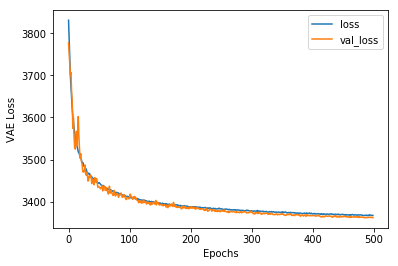

In [9]:
# --------------------------------------------------------------------------------------------------------------------
# Visualize training performance
# --------------------------------------------------------------------------------------------------------------------
history_df = pd.DataFrame(hist.history)
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [10]:
# --------------------------------------------------------------------------------------------------------------------
# Output
# --------------------------------------------------------------------------------------------------------------------

# Save training performance
history_df = pd.DataFrame(hist.history)
history_df = history_df.assign(learning_rate=learning_rate)
history_df = history_df.assign(batch_size=batch_size)
history_df = history_df.assign(epochs=epochs)
history_df = history_df.assign(kappa=kappa)
history_df.to_csv(stat_file, sep='\t')

# Save latent space representation
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')

# Save models
# (source) https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# Save encoder model
encoder.save(model_encoder_file)
    
# serialize weights to HDF5
encoder.save_weights(weights_encoder_file)

# Save decoder model
# (source) https://github.com/greenelab/tybalt/blob/master/scripts/nbconverted/tybalt_vae.py
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

decoder.save(model_decoder_file)
    
# serialize weights to HDF5
decoder.save_weights(weights_decoder_file)